In this lecture on raster DEMs, we discuss some of the properties of DEMs in more detail (resolution, resampling), and relate DEM processing to convolutions, using scipy and numpy. It is also an example of literate programming, where we will write the reaosning first, code later. 

In [14]:
## This workflow requires the following packages
# this cell is hidden form the report
#rasterio
#numpy
#matplotlib
#pysheds
#fiona
#scipy

In [15]:
# this cell is also hidden
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio import plot
%matplotlib inline

# Working with raster data - matrices of values
here, we will work with the SRTM DEM data (heights). We will visually inspect the raster, and check osme of its properties.

In [99]:
# set the path to raster
import os
raster_path = os.path.join(os.path.curdir,"..","data_L5","EastofMelbSRTM.tif")
os.path.exists(raster_path)

True

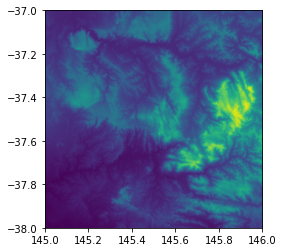

<AxesSubplot:>

In [100]:
src = rasterio.open(raster_path,"r") #opened to read only
plot.show(src)

Name of the dataset - always handy to access, if you are processing many

In [101]:
src.name

'./../data_L5/EastofMelbSRTM.tif'

It is useful to find out how your data are structured - here, how many bands we have. As this is a single-band tif, we only see one band - this will contain the values of the elevations for all cells.

In [102]:
# 
# number of bands (some datasets can have RGB bands and more)
src.count

1

Similarly, we may want to find out the coordinate system of this dataset.

In [103]:
# coordinate system
src.crs

CRS.from_epsg(4326)

Similarly, we may want to explore the bounds of the area. We also identify the value used to capture 'NODATA' cells, and the size of this dataset in number of cells.

In [104]:
# raster shape in crs above
src.bounds

BoundingBox(left=144.9998611111111, bottom=-38.00013888888888, right=146.00013888888887, top=-36.99986111111111)

In [105]:
# value for missing data
src.nodata

-32768.0

Consider what this value means. What would this mean for your analysis, if you encoutnered such a value in the raster?

In [106]:
# size of dataset
src.shape

(3601, 3601)

It is useful to check the distribution of the heigh values in a raster, to get a good understanding of how the terrain is shaped. We see that the majority of the area is realtively low (200m above sea leavel), but it peaks at about 1400m.

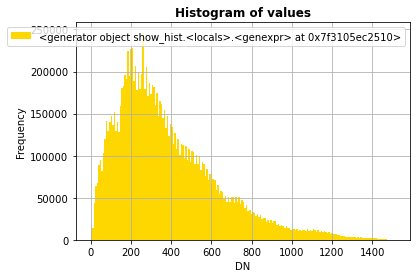

In [109]:
# plot a histogram of the values in the raster. You can specify which band you want, index starts at 1
band = 1
plot.show_hist(src.read(band),bins=200, histtype='stepfilled',title="Histogram of values")

Now that we know the bounds, we can focus on a part of the raster and visualize it - here including a matplotlib function to compute contours.

<AxesSubplot:>

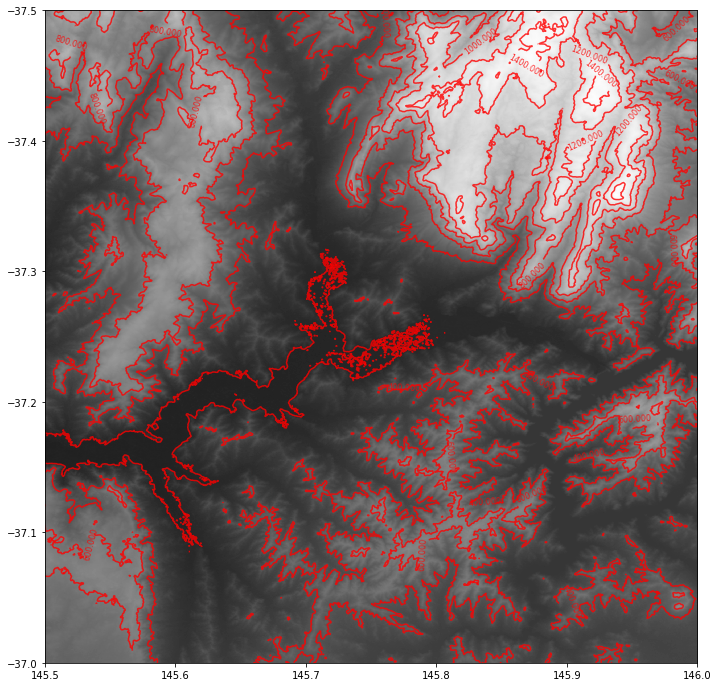

In [110]:
# let's visualize some part of it - a greyscale, and with some contour lines
fig, ax = plt.subplots(1, figsize=(12, 12))
plot.show((src, 1), cmap='Greys_r', interpolation='none', ax=ax)
ax.set_xlim(145.5,146)
ax.set_ylim(-37.0,-37.5)
plot.show((src, 1),contour=True, ax=ax)

As we have opened the dataset outside of a context, we should close it:

In [111]:
src.close()

## Recall - Numpy arrays

In [28]:
# rasters are based on NP arrays. Let's see
x = np.array([[1, 2, 3], [4, 5, 6]], np.int32)
# arrays are indexed from 0 as in all Python.

In [29]:
x

array([[1, 2, 3],
       [4, 5, 6]], dtype=int32)

In [30]:
x[1,2] # get the second row, third column

6

In [31]:
# now the same with our raster
src = rasterio.open(raster_path, 'r+')
arr = src.read() # gets the array read in memory - careful,  may be inefficient
print(arr.shape) # check the shape - see that it is one band, and the size of the array
pt_top_left = arr[0,0,0]
pt_top_left
# Beware, arrays are mutable - you can alter the values unless you are in read only mode!

(1, 3601, 3601)


237

In [32]:
# if you open input outside of context, you must make sure that you close it.
src.close()

## Using contexts 
Contexts for reading/writing makes the structure more undertndable and makes sure you close the file

In [113]:
# using a context syntax to read
# documentation for the modes: http://www.manpagez.com/man/3/fopen/ 
with rasterio.open(raster_path, 'r+') as r: # note the mode
    print(r.closed) # see whether you can read/read/write or write to this
    print(r.mode)
    arr = r.read()  # read all raster values
    print(arr.shape)  # this is a numpy array, with dimensions [band, row, col]
    idx_pt = src.index(145.5,-37.5) # index of the cell containing coordinates: 144.5,-35.5 NOTE: in rasterio 1 this is a function src.xy()
    print("Index of a cell at a given point - here near middle of the raster: "+str(idx_pt[0])+" "+str(idx_pt[1]) ) # 
    coords_pt = src.xy(idx_pt[0],idx_pt[1])  
    print("coordinates of the upper left cell where the index is are: ",coords_pt) # print max and min value of raster
    # alrternatively
    print(src.transform * idx_pt) # using athe affine transformation function

False
r+
(1, 3601, 3601)
Index of a cell at a given point - here near middle of the raster: 1800 1800
coordinates of the upper left cell where the index is are:  (145.5, -37.49999999999999)
(145.4998611111111, -37.4998611111111)


In [117]:
arr[0,idx_pt[0],idx_pt[1]]

665

## Masking by vector feature from shapefile

Masking is the process of settng a region of interest by a vector polygon (vectors are discussed more later). There is a handy package called rasterstats, that does nothing else but that.

In [5]:
# compute the statistics by area - using rasterstats
from rasterstats import zonal_stats
raster_path = os.path.join(os.path.curdir,"..","data_L5","EastofMelbSRTM.tif")
mask_path = os.path.join(os.path.curdir,"..","data_L5","melb_shape.shp")
zonal_stats(mask_path, raster_path,
            stats="count min mean max median")


[{'min': 163.0,
  'max': 1037.0,
  'mean': 506.010389920481,
  'count': 1172675,
  'median': 477.0},
 {'min': 116.0,
  'max': 1514.0,
  'mean': 822.1193088595089,
  'count': 1208611,
  'median': 859.0}]

In [6]:
## this is a way to read shp data in - from example above. 
## We are going to discuss this more later, 
## for now, just have a look at it - just so you know.
## We are using geopandas for this
import geopandas as gpd


<AxesSubplot:>

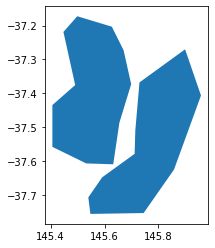

In [9]:
mask = gpd.read_file(mask_path)
mask.plot()

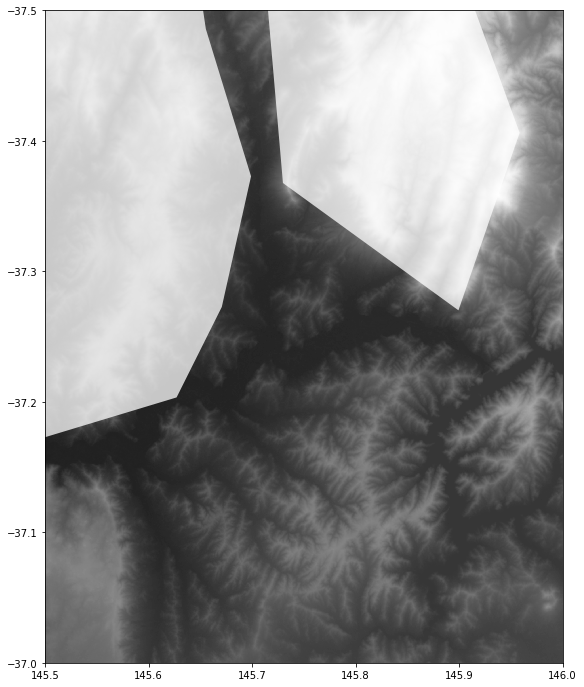

In [34]:
with rasterio.open(raster_path, 'r+') as rio:
    fig, ax = plt.subplots(1, figsize=(12, 12))
    plot.show((rio, 1), cmap='Greys_r', interpolation='none', ax=ax)
    ax.set_xlim(145.5,146)
    ax.set_ylim(-37.0,-37.5)
    #show(rgb.read(), transform=rgb.transform, ax=ax)
    mask.plot(ax=ax, color='white', alpha=.75) ## alpha is the transparency setting
    plt.show()

## further reading

An excellent tutorial on workingwith rasters is in here:
    [https://automating-gis-processes.github.io/CSC/notebooks/L5/raster-map-algebra.html#](https://automating-gis-processes.github.io/CSC/notebooks/L5/raster-map-algebra.html#)

# Focal operations using convolutions with Scipy
As discussed in the lecture, convolutions perform element-wise multiplication of the weights in a kernel with the values in an input raster. The size of the kernel is an odd number, usually square. Most common are 3x3 and 5x5 kernels. We will use a 3x3 kernel. We will demonstrate how the convolution works on a made up dataset first.

In [118]:
from scipy import signal
from scipy import misc # this is a module containing some demo image data, loaded only for illustration..
import math

In [119]:
# read a demo dataset
ascent = misc.ascent()

In [120]:
ascent

array([[ 83,  83,  83, ..., 117, 117, 117],
       [ 82,  82,  83, ..., 117, 117, 117],
       [ 80,  81,  83, ..., 117, 117, 117],
       ...,
       [178, 178, 178, ...,  57,  59,  57],
       [178, 178, 178, ...,  56,  57,  57],
       [178, 178, 178, ...,  57,  57,  58]])

The 'Scharr filter' is one of the used filters for the detection of gradients (in images, but also in DEMs). 
It is here defined using imaginary components for the y component (differentiation in the Y direction). 
Note how the kernel of the filter changes uniformly:
- form left to right (x, real component), and 
- from top to bottom ( imaginary component, y direction)
![image.png](../figs/scharr.png)
This definition of the filter is flipped form the inout below. Why? Can you recall what happens when we apply a convolution? What does it mean when you are encoding filters, in general?


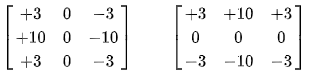

In [121]:
scharr = np.array([[ -3-3j, 0-10j,  +3 -3j],
                   [-10+0j, 0+ 0j, +10 +0j],
                   [ -3+3j, 0+10j,  +3 +3j]]) # Gx + j*Gy
scharr_orig = np.array([[ 3+3j, 0+10j,  -3 -3j],
                   [10+0j, 0+ 0j, -10 +0j],
                   [ +3-3j, 0-10j,  -3 -3j]])

We can then compute the maximal gradient, using the convolve2d function from scipy.signal. We will then look at the values of the gradient, and at its aspect (direction). We will look at the values of aspect in detail. Think, what are the values of the gradient in? How could you convert them to a meaningful value, either in percentage or in degrees? What about the aspect? Recall, we are spatial analysts, we would want these oriented form the north (azimut). Also note, that the aspect is measure in the direction of the gradeint increase in image analysis, and in the direction of slope drop in geography!

In [122]:
grad = signal.convolve2d(ascent, scharr, boundary='symm', mode='same')
grad_sch_orig = signal.convolve2d(ascent, scharr_orig, boundary='symm', mode='same')

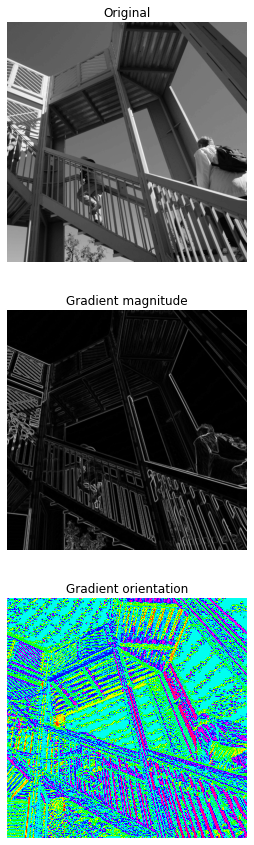

In [123]:
# plotting side by side the orignal image, the detected changes.
import matplotlib.pyplot as plt
fig, (ax_orig, ax_mag, ax_ang) = plt.subplots(3, 1, figsize=(6, 15))
ax_orig.imshow(ascent, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_mag.imshow(np.absolute(grad), cmap='gray')
ax_mag.set_title('Gradient magnitude')
ax_mag.set_axis_off()
ax_ang.imshow(np.angle(grad), cmap='hsv') # hsv is cyclic, like angles
ax_ang.set_title('Gradient orientation')
ax_ang.set_axis_off()
fig.show()

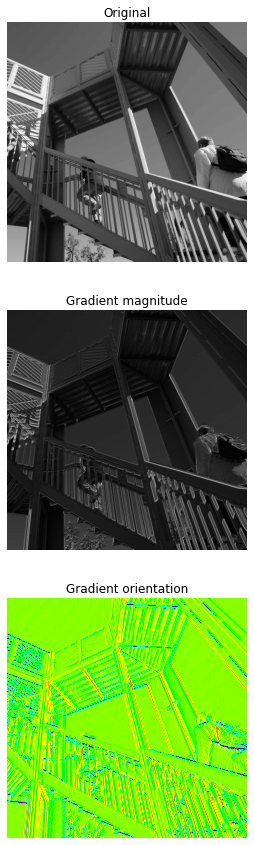

In [124]:
# plotting side by side the orignal image, the detected changes.
import matplotlib.pyplot as plt
fig, (ax_orig, ax_mag, ax_ang) = plt.subplots(3, 1, figsize=(6, 15))
ax_orig.imshow(ascent, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_mag.imshow(np.absolute(grad_sch_orig), cmap='gray')
ax_mag.set_title('Gradient magnitude')
ax_mag.set_axis_off()
ax_ang.imshow(np.angle(grad_sch_orig), cmap='hsv') # hsv is cyclic, like angles
ax_ang.set_title('Gradient orientation')
ax_ang.set_axis_off()
fig.show()

In [125]:
np.angle(grad)* 180 / np.pi

array([[  90.        ,  102.99461679,  135.        , ...,    0.        ,
           0.        ,    0.        ],
       [  93.81407483,  123.23171107,  159.44395478, ...,    0.        ,
           0.        ,    0.        ],
       [ 180.        ,  180.        ,  180.        , ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [ -90.        ,  -90.        ,  -90.        , ...,  135.        ,
         113.96248897,   85.42607874],
       [   0.        ,    0.        ,    0.        , ...,  153.74975763,
         127.40535663,  -66.80140949],
       [   0.        ,    0.        ,    0.        , ...,  174.42314135,
        -159.44395478, -135.        ]])

In [126]:
np.angle(grad_sch_orig)* 180 / np.pi

array([[-90.        , -89.65963304, -89.6527571 , ..., -90.        ,
        -90.        , -90.        ],
       [-89.67259911, -87.86225027, -88.13737905, ..., -90.        ,
        -90.        , -90.        ],
       [-88.83561196, -85.81508387, -86.97498809, ..., -90.        ,
        -90.        , -90.        ],
       ...,
       [-90.        , -90.        , -90.        , ..., -82.72855445,
        -86.47854662, -91.03691446],
       [-90.        , -90.        , -90.        , ..., -63.11752393,
        -87.92612863, -90.51308282],
       [-90.        , -90.        , -90.        , ..., -39.51976146,
        -87.27368901, -87.73721019]])

In [127]:
small_matrix_data = np.array([[ 1, 2,  3],
                   [1,2,3],
                   [ 1,2,3]])

In [128]:
scharr_x = np.array([[ -3, 0, 3],
                   [-10, 0, 10 ],
                   [ -3, 0,  3 ]]) # Gx 
scharr_y = np.array([[ -3, -10,  -3],
                   [0,  0, 0],
                   [ 3, 10,  3]]) # Gy
scharr_x_orig = np.array([[ 3, 0, -3],
                   [10, 0, -10 ],
                   [ 3, 0,  -3 ]]) # Gx 
scharr_y_orig = np.array([[ 3, 10,  3],
                   [0,  0, 0],
                   [ -3, -10,  -3]]) # Gy
sobel_x = np.array([[ 1, 0,  -1],
                   [2, 0, -2],
                   [ 1, 0,  -1]])
sobel_y = np.array([[ 1, 2,  1],
                   [0, 0, 0],
                   [ -1, 0,  1]])

In [129]:
grad_x = signal.convolve2d(small_matrix_data, sobel_x, boundary='fill', mode='valid')
grad_y = signal.convolve2d(small_matrix_data, sobel_y, boundary='fill', mode='valid')

grad_sch_x = signal.convolve2d(small_matrix_data, scharr_x, boundary='fill', mode='valid')
grad_sch_y = signal.convolve2d(small_matrix_data, scharr_y, boundary='fill', mode='valid')

gradient = np.tan(math.sqrt((grad_x**2)+(grad_y**2)))
aspect = np.arctan2(grad_y,grad_x)* 180 / np.pi

gradient_sch = np.tan(math.sqrt((grad_sch_x**2)+(grad_sch_y**2)))
aspect_sch = np.arctan2(grad_sch_y,grad_sch_x)* 180 / np.pi



In [130]:
aspect

array([[36.86989765]])

In [47]:
np.absolute(math.sqrt((grad_sch_x**2)+(grad_sch_y**2)))

32.0

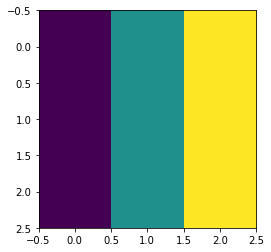

<AxesSubplot:>

In [48]:
plot.show(small_matrix_data)

In [49]:
help(np.angle)

Help on function angle in module numpy:

angle(z, deg=False)
    Return the angle of the complex argument.
    
    Parameters
    ----------
    z : array_like
        A complex number or sequence of complex numbers.
    deg : bool, optional
        Return angle in degrees if True, radians if False (default).
    
    Returns
    -------
    angle : ndarray or scalar
        The counterclockwise angle from the positive real axis on the complex
        plane in the range ``(-pi, pi]``, with dtype as numpy.float64.
    
        .. versionchanged:: 1.16.0
            This function works on subclasses of ndarray like `ma.array`.
    
    See Also
    --------
    arctan2
    absolute
    
    Notes
    -----
    Although the angle of the complex number 0 is undefined, ``numpy.angle(0)``
    returns the value 0.
    
    Examples
    --------
    >>> np.angle([1.0, 1.0j, 1+1j])               # in radians
    array([ 0.        ,  1.57079633,  0.78539816]) # may vary
    >>> np.angle(1+1j, d

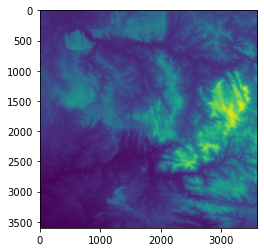

In [131]:
with rasterio.open(raster_path, 'r+') as src:
    data = src.read()[0]# your first array with data
    kernel = np.ones((3,3))/9
    C = signal.convolve2d(data,kernel, 'valid')
    plot.show(C)

## Raindrops
find where rain flows.
taken from http://www2.geog.ucl.ac.uk/~plewis/geogg122-2011-12/dem2.html 

In [132]:
def padding(dem,size=1):
    '''
    Apply a border of size [pixel] to a spatial dataset

    Return the padded data with the original centred in the array
    '''
    out = np.zeros([dem.shape[0]+2*size,dem.shape[1]+2*size])
    out[:,:] = np.max(dem)+1
    out[size:-size,size:-size] = dem
    return out

In [133]:
def localMin(dem):
    '''
    We wish to return the location of the minimum grid value
    in a neighbourhood.

    We assume the array is 2D and defined (y,x)

    We return wx,wy which are the cell displacements in x and y directions.

    '''
    wy = np.zeros_like(dem).astype(int)
    wx = np.zeros_like(dem).astype(int)
    winx = np.ones([3,3])
    for i in range(3):
        winx[:,i] = i - 1
    winy = winx.transpose()
    demp = padding(dem,size=1)
    for y in np.arange(1,demp.shape[0]-1):
        for x in np.arange(1,demp.shape[1]-1):
            win = demp[y-1:y+2,x-1:x+2]
            ww = np.where(win == np.min(win))
            whereX = winx[ww][0]
            whereY = winy[ww][0]
            wy[y-1,x-1] = whereY
            wx[y-1,x-1] = whereX
    return wx,wy


In [135]:
with rasterio.open(raster_path, 'r+') as src:
    data = src.read()[0]# your first band array with data
    (wx,wy) = localMin(data)
    plot(wx)

TypeError: 'module' object is not callable

# slope and aspect
    based on: http://www2.geog.ucl.ac.uk/~plewis/geogg122-2011-12/dem2.html

In [63]:
def gaussianFilter(sizex,sizey=None,scale=0.333):
    '''
    Generate and return a 2D Gaussian function
    of dimensions (sizex,sizey)

    If sizey is not set, it defaults to sizex
    A scale can be defined to widen the function (default = 0.333)
    '''
    sizey = sizey or sizex
    x, y = np.mgrid[-sizex:sizex+1, -sizey:sizey+1]
    g = np.exp(-scale*(x**2/float(sizex)+y**2/float(sizey)))
    return g/g.sum()

In [64]:
def grad2d(dem):
    '''
    Calculate the slope and gradient of a DEM
    '''
    from scipy import signal
    f0 = gaussianFilter(3)
    I = signal.convolve(dem,f0,mode='valid') # applies smooothing by gaussian filter
    f1 = np.array([[-1,0,1],[-2,0,2],[-1,0,1]]) # SOBEL FILTER 
    f2 = f1.transpose()
    g1 = signal.convolve(I,f1,mode='valid')
    g2 = signal.convolve(I,f2,mode='valid')
    slope = np.sqrt(g1**2 + g2**2)
    aspect = np.arctan2(g2,g1)
    return slope, aspect

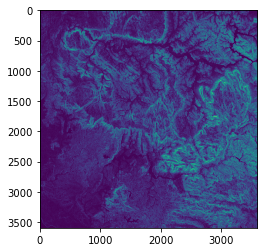

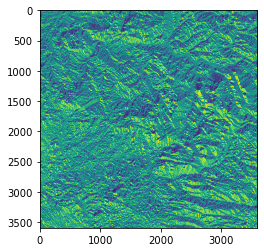

In [65]:
with rasterio.open(raster_path, 'r+') as src:
    data = src.read()[0]# your first array with data
    slope, aspect = grad2d(data)
    plot.show(slope)
    plot.show(aspect)

In [ ]:
result = scipy.ndimage.convolve(your_raster_as_numpy_array, weights=kernel) / kernel.size

In [61]:
from scipy.ndimage.filters import generic_filter as gf

kernel = np.ones((3,3))
circular_mean = gf(data, np.mean, footprint=kernel) # size=(3,3)